In [1]:
import mxnet as mx
import gluonnlp as nlp
import matplotlib.pyplot as plt
import sklearn
from tqdm.notebook import tqdm

# Local Libraries
# Load Model locally
import textcnn
# Load helper functions
import utils

# Set Context (change to cpu if no gpu available)
# ctx = mx.cpu()
ctx = mx.gpu()

[nltk_data] Downloading package punkt to /home/andreto/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/andreto/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/andreto/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
w2v = nlp.embedding.Word2Vec()

In [3]:
nlp.embedding.list_sources('Word2Vec')

['GoogleNews-vectors-negative300',
 'freebase-vectors-skipgram1000-en',
 'freebase-vectors-skipgram1000']

In [4]:
embed_size = len(w2v["man"])
print(embed_size)

300


In [15]:
# Loading the dataset
full_train_dataset, test_dataset = [nlp.data.IMDB(root='data/imdb', segment=segment)
                               for segment in ('train', 'test')]

# Dataset Sizes
print("Size of Train Set:", len(full_train_dataset), " (no valid split yet)")
print("Size of Test  Set:", len(test_dataset))

Size of Train Set: 25000  (no valid split yet)
Size of Test  Set: 25000


In [6]:
print(test_dataset[0][0])

I went and saw this movie last night after being coaxed to by a few friends of mine. I'll admit that I was reluctant to see it because from what I knew of Ashton Kutcher he was only able to do comedy. I was wrong. Kutcher played the character of Jake Fischer very well, and Kevin Costner played Ben Randall with such professionalism. The sign of a good movie is that it can toy with our emotions. This one did exactly that. The entire theater (which was sold out) was overcome by laughter during the first half of the movie, and were moved to tears during the second half. While exiting the theater I not only saw many women in tears, but many full grown men as well, trying desperately not to let anyone see them crying. This movie was great, and I suggest that you go see it before you judge.


In [16]:
# Filtering for size
# Starting data samples are positive reviews, and ending data samples are negative reviews
# Retrieving a balanced sample of both sentiments
full_train_dataset = full_train_dataset[:3125] + full_train_dataset[-3125:]
print("Size of Train Set (Post-filter):", len(full_train_dataset), " (no valid split yet)")
print("Size of Test  Set (Post-filter):", len(test_dataset))

Size of Train Set (Post-filter): 6250  (no valid split yet)
Size of Test  Set (Post-filter): 25000


In [8]:
# Training Dataset Split 40/10
# Test Dataset already provided separately
from sklearn.model_selection import train_test_split

train_dataset, val_dataset = train_test_split(full_train_dataset, test_size=int(0.2*len(full_train_dataset)), random_state=42)

In [17]:
# Final Dataset Sizes
print("Size of Train Set:", len(train_dataset))
print("Size of Val   Set:", len(val_dataset))
print("Size of Test  Set:", len(test_dataset))

Size of Train Set: 5000
Size of Val   Set: 1250
Size of Test  Set: 25000


In [10]:
# Each input in a batch, needs to have the same length
# We need to apply a batchify function to pad with zeros (if necessary)
# On the output, we just stack them together to get a batch-size array
batchify_fn = nlp.data.batchify.Tuple(nlp.data.batchify.Pad(axis=1, pad_val=0),
                                      nlp.data.batchify.Stack())

In [11]:
def process_dataset_sample(review, score=None):
    # Processing inputs & applying embeddings
    processed_review = utils.process_words(utils.clean_text(review))
    embeddings = w2v[processed_review].transpose()

    # A negative review has a score <= 4
    # A positive review has a score >= 7 out of 10
    sentiment = None
    if score:
        sentiment = mx.nd.array(score > 5, dtype='float32', ctx=mx.cpu()).asnumpy()
    return embeddings, sentiment

In [12]:
# Dataset processing
train_set = []
for review, score in tqdm(train_dataset):
    embeddings, sentiment = process_dataset_sample(review, score)
    train_set.append((embeddings, sentiment))

  0%|          | 0/5000 [00:00<?, ?it/s]

In [13]:
val_set = []
for review, score in tqdm(val_dataset):
    embeddings, sentiment = process_dataset_sample(review, score)
    val_set.append((embeddings, sentiment))

  0%|          | 0/1250 [00:00<?, ?it/s]

In [14]:
from importlib import reload
reload(textcnn)

# CNN with 3 parallel filters
text_cnn = textcnn.TextCNN([3, 4, 5], [embed_size, embed_size, embed_size])
text_cnn.initialize(mx.init.MSRAPrelu(), ctx)

# Formatting single input as expected for the network
seq_output, _ = process_dataset_sample(test_dataset[0][0])
seq_output_reshaped = mx.nd.array(seq_output, ctx=ctx).expand_dims(axis=0)

print(seq_output_reshaped.shape)

text_cnn.summary(seq_output_reshaped)

(1, 300, 72)
Extension horovod.torch has not been built: /home/ubuntu/anaconda3/envs/mxnet_p37/lib/python3.7/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-37m-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.
[2022-08-02 13:09:00.109 ip-172-31-28-47:9923 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-08-02 13:09:00.137 ip-172-31-28-47:9923 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                                (1, 300, 72)               0
        Activation-1                     <Symbol conv0_relu_fwd>               0
        Activation-2                 

In [18]:
review_sentiment = text_cnn(seq_output_reshaped)
# We can omit sigmoid processing, outputs of the network
# with positive values are positive reviews
if review_sentiment >= 0:
    print(review_sentiment, "The review is positive")
else:
    print(review_sentiment, "The review is negative")


[[0.12194177]]
<NDArray 1x1 @gpu(0)> The review is positive


In [19]:
epochs = 5
batch_size = 4

model_file_name = "w2v_textcnn.params"

loss_fn = mx.gluon.loss.SigmoidBCELoss()
trainer = mx.gluon.Trainer(text_cnn.collect_params(), "adam", {"learning_rate": 0.001})

training_loss, validation_loss, validation_acc = text_cnn.train(
    loss_fn,
    trainer,
    epochs,
    batch_size,
    train_set,
    val_set,  
    batchify_fn,
    ctx,
    model_file_name)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

/home/andreto/.local/lib/python3.7/site-packages/gluonnlp/data/batchify/batchify.py:269: UserWarning: Using Pad with NDArrays is discouraged for speed reasons. Instead you should pad your data while it is still a list and before converting to an NDArray. Alternatively you can consider inputting a numpy.ndarray.
  'Using Pad with NDArrays is discouraged for speed reasons. '


  0%|          | 0/312 [00:00<?, ?it/s]

E:    0, TrL: 0.524825, VL: 0.378461, VAcc: 0.832000 --- Updating saved model


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

E:    1, TrL: 0.340916, VL: 0.343979, VAcc: 0.845600 --- Updating saved model


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

E:    2, TrL: 0.226378, VL: 0.318877, VAcc: 0.868800 --- Updating saved model


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

E:    3, TrL: 0.142948, VL: 0.322480, VAcc: 0.863200


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

E:    4, TrL: 0.084104, VL: 0.405675, VAcc: 0.843200


In [22]:
# Retrieve best model from training
text_cnn.load_parameters(model_file_name)

review_sentiment = text_cnn(seq_output_reshaped)
# We can omit sigmoid processing, outputs of the network
# with positive values are positive reviews
if review_sentiment >= 0:
    print(review_sentiment, "The review is positive")
else:
    print(review_sentiment, "The review is negative")


[[2.3616772]]
<NDArray 1x1 @gpu(0)> The review is positive


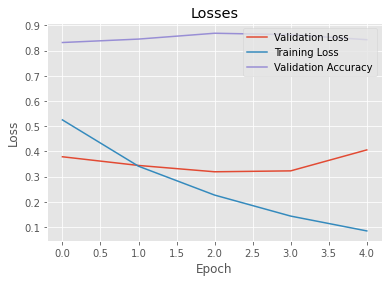

In [23]:
# plot losses and validation accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(range(0, epochs), validation_loss, label="Validation Loss")
plt.plot(range(0, epochs), training_loss, label="Training Loss")
plt.plot(range(0, epochs), validation_acc, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.title("Losses")
plt.show()

In [24]:
# Quantitative Evaluation on Test Set
test_set = []

# Test set size can be limited in not enough memory
# It is encouraged to increase this value to the full size of test set (25000 samples)
for review, score in tqdm(test_dataset):
    embeddings, sentiment = process_dataset_sample(review, score)
    test_set.append((embeddings, sentiment))

  0%|          | 0/25000 [00:00<?, ?it/s]

In [25]:
# Processing Test dataset for confussion matrix
num_test_batches = int(len(test_set) / batch_size)

# Iterator on Test dataset
test_data_iterator = mx.gluon.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    batchify_fn=batchify_fn)

In [26]:
# Confussion Matrix Computation (Test set)
class_outputs = mx.nd.empty(shape=(len(test_set),))
labels = mx.nd.empty(shape=(len(test_set),))

test_acc = mx.metric.Accuracy()
cumulative_test_loss = 0

for index, (data, label) in enumerate(tqdm(test_data_iterator, total=num_test_batches)):
    
    # Add labels for Confussion Matrix
    labels[index * batch_size:(index + 1) * batch_size] = label
                
    # Processing data from data iterator
    data = data.as_in_context(ctx)
    label = label.as_in_context(ctx)

    output = text_cnn(data)
    test_loss = loss_fn(output, label)
    current_test_loss = mx.nd.mean(test_loss).asscalar()
    cumulative_test_loss += current_test_loss / num_test_batches

    # Accuracy
    # Comparison between  labels and values output
    # Applying threshold for binary classification
    # No sigmoid necessary as outputs of the network
    # with positive values are positive reviews
    class_output = (output >= 0).astype("uint8").transpose()
    class_outputs[index * batch_size:(index + 1) * batch_size] = class_output
    test_acc.update(label, class_output[0])

test_acc_value = test_acc.get()[1]
print("Final Test Accuracy:", test_acc_value)

  0%|          | 0/6250 [00:00<?, ?it/s]

Final Test Accuracy: 0.83696


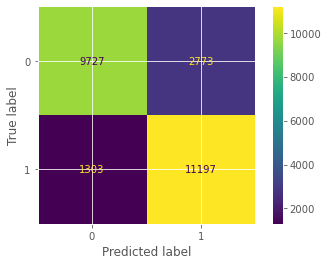

In [27]:
# Plot the CM
confusion_matrix = sklearn.metrics.confusion_matrix(labels.asnumpy(), class_outputs.asnumpy())
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix)
disp.plot()